### ML Zoomcamp Capstone Project

#### Regression problem.  Medical Insurance Cost

In [109]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn import linear_model

#### Import and clean up

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
numerical = ['age', 'bmi', 'children', 'charges']
categorical = ['sex', 'smoker', 'region']

In [8]:
for c in categorical:
    df[c] = df[c].astype('category')
    df[f"{c}_cat"] = df[c].cat.codes

In [9]:
#training-test split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=5)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=5)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(df_full_train), len(df_test), len(df_train), len(df_val)

(1070, 268, 802, 268)

#### EDA

In [10]:
for i in categorical:
    print(i + '   ' +str(df_train[i].unique()))

sex   ['female', 'male']
Categories (2, object): ['female', 'male']
smoker   ['no', 'yes']
Categories (2, object): ['no', 'yes']
region   ['southwest', 'southeast', 'northeast', 'northwest']
Categories (4, object): ['northeast', 'northwest', 'southeast', 'southwest']


In [11]:
for i in numerical:
    print(i, df_train[i].max(), df_train[i].min())

age 64 18
bmi 53.13 17.195
children 5 0
charges 60021.39897 1131.5066


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         802 non-null    int64   
 1   sex         802 non-null    category
 2   bmi         802 non-null    float64 
 3   children    802 non-null    int64   
 4   smoker      802 non-null    category
 5   region      802 non-null    category
 6   charges     802 non-null    float64 
 7   sex_cat     802 non-null    int8    
 8   smoker_cat  802 non-null    int8    
 9   region_cat  802 non-null    int8    
dtypes: category(3), float64(2), int64(2), int8(3)
memory usage: 30.3 KB


In [13]:
df_train.describe()

,age,bmi,children,charges,sex_cat,smoker_cat,region_cat
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,39.563591,30.761789,1.142145,13301.011611,0.487531,0.198254,1.511222
std,13.922886,6.036577,1.207444,11898.967448,0.500156,0.398934,1.098404
min,18.000000,17.195000,0.000000,1131.506600,0.000000,0.000000,0.000000
25%,27.000000,26.336250,0.000000,4839.916763,0.000000,0.000000,1.000000
50%,40.000000,30.497500,1.000000,9556.297050,0.000000,0.000000,2.000000
75%,52.000000,34.560000,2.000000,16639.912515,1.000000,0.000000,2.000000
max,64.000000,53.130000,5.000000,60021.398970,1.000000,1.000000,3.000000


<Axes: xlabel='charges', ylabel='Count'>

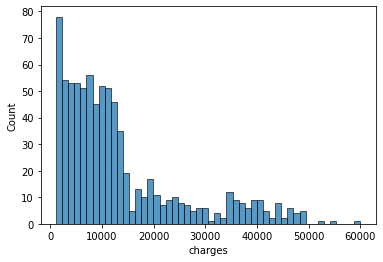

In [14]:
sns.histplot(df_train.charges, bins=50)


<Axes: xlabel='charges', ylabel='Count'>

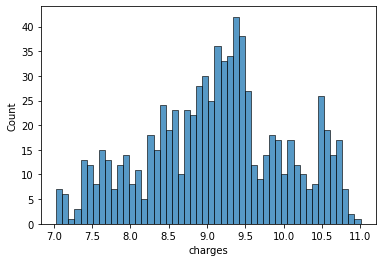

In [15]:
charges_logs = np.log1p(df_train.charges)

sns.histplot(charges_logs, bins=50)

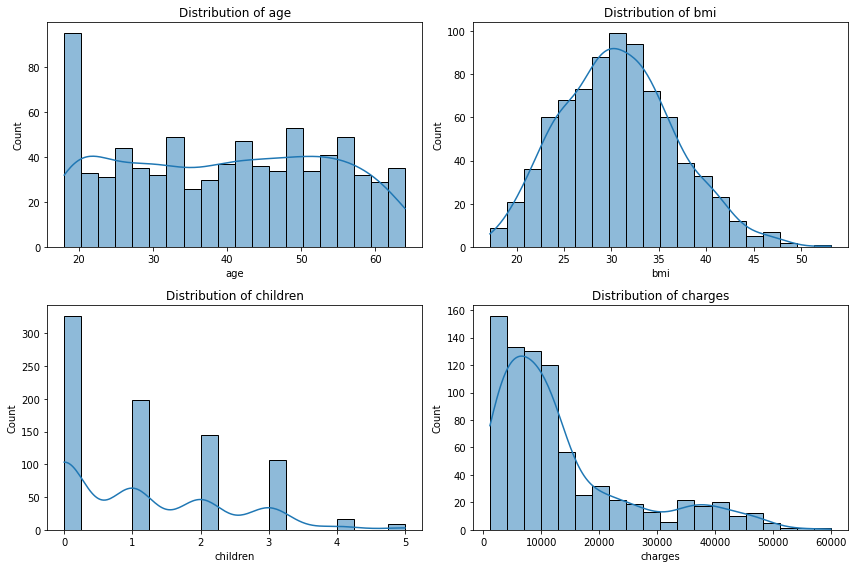

In [16]:
# histograms to show distribution of numerical fields

plt.figure(figsize=(12, 8))
plot = 1
for i in numerical : #  Age distribution
    plt.subplot(2, 2, plot)
    sns.histplot(data=df_train, x=i, bins=20, kde=True)
    plt.title(f'Distribution of {i}')
    plot += 1

plt.tight_layout()
plt.show()

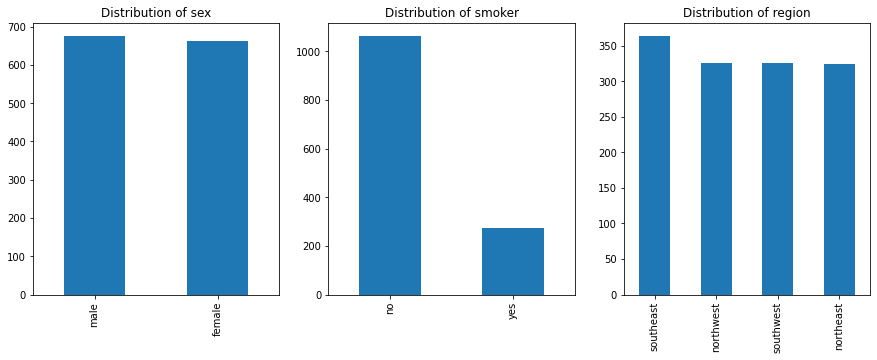

In [17]:
# plots to show distribution of categorical variables
plt.figure(figsize=(12, 20))
plot = 1
for c in categorical:
    plt.subplot(1, 3, plot)
    data = df[c].value_counts()
    data.plot(kind='bar',figsize=(15,5),xlabel = '')
    plt.title(f'Distribution of {c}')
    plot += 1
#plt.tight_layout()
plt.show()

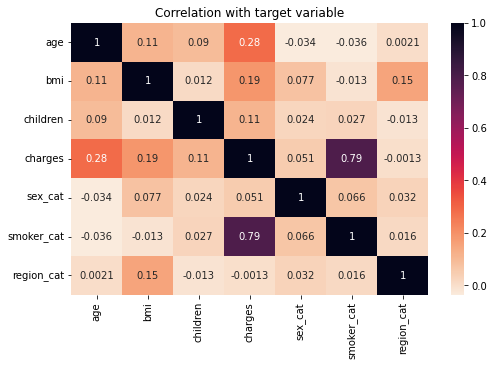

In [18]:
df_corr = df_train[['age','bmi', 'children', 'charges',
       'sex_cat', 'smoker_cat', 'region_cat']]
corr_matrix = df_corr.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='rocket_r')
plt.title('Correlation with target variable')
plt.show()

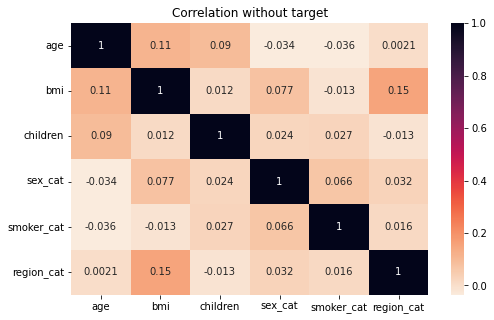

In [19]:
df_corr = df_train[['age','bmi', 'children',
       'sex_cat', 'smoker_cat', 'region_cat']]
corr_matrix = df_corr.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='rocket_r')
plt.title('Correlation without target')
plt.show()

####  Train a linear regression model

- prepare the y data using log1
- train linear regression model
- validate first model
- test regularization using different values of r and compare performance

In [87]:
y_train = np.log1p(df_train.charges.values)
y_val = np.log1p(df_val.charges.values)

X_train = np.array(df_train[['age','bmi', 'children',
        'sex_cat','smoker_cat','region_cat']])
X_val = np.array(df_val[['age','bmi', 'children',
        'sex_cat','smoker_cat','region_cat']])


In [88]:
X_train

array([[38.   , 34.8  ,  2.   ,  0.   ,  0.   ,  3.   ],
       [43.   , 32.6  ,  2.   ,  1.   ,  0.   ,  3.   ],
       [39.   , 34.1  ,  2.   ,  1.   ,  0.   ,  2.   ],
       ...,
       [63.   , 37.7  ,  0.   ,  0.   ,  1.   ,  3.   ],
       [35.   , 34.105,  3.   ,  0.   ,  1.   ,  1.   ],
       [27.   , 17.955,  2.   ,  0.   ,  1.   ,  0.   ]])

In [89]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]


In [90]:
train_linear_regression(X_train, y_train)

(7.018276116376125,
 array([ 0.03414809,  0.01411772,  0.10086859, -0.07507641,  1.54600825,
        -0.05111794]))

In [91]:
w0, w = train_linear_regression(X_train, y_train)

In [92]:
w0

7.018276116376125

In [93]:
w

array([ 0.03414809,  0.01411772,  0.10086859, -0.07507641,  1.54600825,
       -0.05111794])

In [94]:
y_pred = w0 + X_train.dot(w)
y_pred

array([ 8.85558322,  8.92018826,  8.85589043,  9.08563545,  7.97113525,
        8.41863394,  8.66815743,  7.98701396,  8.74661124,  9.60528187,
        9.28430974,  9.21021253,  8.56560059,  8.14388075,  9.19016911,
        8.28154996,  9.1686253 ,  9.10733977,  9.33091996,  9.43307689,
        9.61705747,  8.33802088,  9.41417   , 10.14165568, 10.58265461,
        8.48948718,  9.87309126,  9.18902624,  9.3749986 ,  9.1452781 ,
        8.29589623, 10.10237609,  7.93444384,  9.77020699,  9.11209063,
        9.264993  ,  8.06420678,  8.85356197,  8.79928897,  8.82124953,
        9.23293459,  9.02048129,  9.61087307,  8.49348304,  9.097364  ,
        8.97454113,  9.02783709,  8.93975441,  9.47596425,  8.39031611,
        7.99446899,  9.81179802, 10.27775355,  7.92430891,  9.776791  ,
        8.55219849,  9.30606684,  9.58760744,  9.92943151,  8.44342358,
        8.43702648,  9.01735267,  8.03956079,  7.92173789, 10.09568351,
       10.69577894,  8.51073993,  8.4786557 ,  8.91994727,  9.22

In [95]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [96]:
rmse(y_train, y_pred).round(4)

0.448

<Axes: ylabel='Count'>

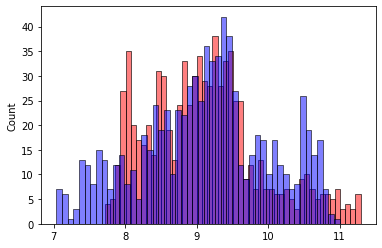

In [97]:


sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)



In [98]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [99]:
r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
Scores = []
for i in r:    
    w0, w = train_linear_regression_reg(X_train, y_train, i)

    y_pred = w0 + X_val.dot(w)
    Error = rmse(y_val, y_pred).round(2)
    Scores.append(Error)
    print('RMSE = ' + str(Error) + '  r = ' + str(i))

RMSE = 0.46  r = 0
RMSE = 0.46  r = 1e-06
RMSE = 0.46  r = 0.0001
RMSE = 0.46  r = 0.001
RMSE = 0.46  r = 0.01
RMSE = 0.46  r = 0.1
RMSE = 0.47  r = 1
RMSE = 0.53  r = 5
RMSE = 0.62  r = 10


In [100]:
df_train

,age,sex,bmi,children,smoker,region,charges,sex_cat,smoker_cat,region_cat
0,38,female,34.800,2,no,southwest,6571.54400,0,0,3
1,43,male,32.600,2,no,southwest,7441.50100,1,0,3
2,39,male,34.100,2,no,southeast,23563.01618,1,0,2
3,46,male,33.345,1,no,northeast,8334.45755,1,0,0
4,18,male,29.370,1,no,southeast,1719.43630,1,0,2
...,...,...,...,...,...,...,...,...,...,...
797,51,female,37.730,1,no,southeast,9877.60770,0,0,2
798,55,male,28.975,0,no,northeast,10796.35025,1,0,0
799,63,female,37.700,0,yes,southwest,48824.45000,0,1,3
800,35,female,34.105,3,yes,northwest,39983.42595,0,1,1


In [101]:
# test stability of model with different randomization

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for i in seeds:    
    df = pd.read_csv('insurance.csv')
    n = len(df)
    idx = np.arange(n)
    np.random.seed(i)
    np.random.shuffle(idx)
    df = df.iloc[idx]
    df = df.reset_index(drop=True)
    df = df.fillna(0)

    for c in categorical:
      df[c] = df[c].astype('category')
      df[f"{c}_cat"] = df[c].cat.codes

    df_full_train, df_test = train_test_split(df, test_size=0.2)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    X_train = np.array(df_train[['age','bmi', 'children',
       'sex_cat', 'smoker_cat', 'region_cat']])
    X_val = np.array(df_val[['age','bmi', 'children',
       'sex_cat', 'smoker_cat', 'region_cat']])
    X_test = np.array(df_test[['age','bmi', 'children',
       'sex_cat', 'smoker_cat', 'region_cat']])

    y_train = np.log1p(df_train.charges.values)
    y_val = np.log1p(df_val.charges.values)
    y_test = np.log1p(df_test.charges.values)

    w0, w = train_linear_regression(X_train, y_train)

    y_pred = w0 + X_val.dot(w)
    error = rmse(y_val, y_pred).round(2)
    scores.append(error)
    print('RMSE = ' + str(error) + '  seed ' + str(i))

RMSE = 0.47  seed 0
RMSE = 0.44  seed 1
RMSE = 0.47  seed 2
RMSE = 0.38  seed 3
RMSE = 0.36  seed 4
RMSE = 0.42  seed 5
RMSE = 0.41  seed 6
RMSE = 0.45  seed 7
RMSE = 0.47  seed 8
RMSE = 0.48  seed 9


In [102]:
np.std(scores).round(4)

0.0393

In [103]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

Ridge()

In [107]:
y_pred = clf.predict(X_val)
error = rmse(y_val, y_pred).round(2)
error


0.48

In [110]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)

Lasso(alpha=0.1)

In [111]:
y_pred = clf.predict(X_val)
error = rmse(y_val, y_pred).round(2)
error

0.55

#### Decision Tree Regressor

In [114]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer


In [115]:
del df_train['charges']

In [116]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [117]:
dt = DecisionTreeRegressor(max_depth = 5)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [118]:
y_pred = dt.predict(X_val)
rmse(y_val, y_pred)

0.4188456228045922

In [119]:
values = [10, 15, 20, 25]
scores = []
for v in values:
    for n in range (10, 201, 10):
        dt = DecisionTreeRegressor(min_samples_leaf=n, random_state=1, max_depth = v)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)  
        scores.append((v, n, rmse(y_val, y_pred)))

In [122]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'rmse'])
df_scores

,max_depth,min_samples_leaf,rmse
0,10,10,0.409465
1,10,20,0.392179
2,10,30,0.386114
3,10,40,0.400088
4,10,50,0.401965
...,...,...,...
75,25,160,0.842942
76,25,170,0.842942
77,25,180,0.842942
78,25,190,0.842942


In [126]:
df_scores[df_scores.rmse == df_scores.rmse.min()]

,max_depth,min_samples_leaf,rmse
2,10,30,0.386114
22,15,30,0.386114
42,20,30,0.386114
62,25,30,0.386114


In [138]:
values = [2, 5,6,7, 8,10, 15, 20, 25]
scores = []
for v in values:
    for n in range (20, 40, 5):
        dt = DecisionTreeRegressor(min_samples_leaf=n, random_state=1, max_depth = v)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)  
        scores.append((v, n, rmse(y_val, y_pred)))

In [139]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'rmse'])
df_scores[df_scores.rmse == df_scores.rmse.min()]

,max_depth,min_samples_leaf,rmse
11,6,35,0.378799
15,7,35,0.378799
19,8,35,0.378799
23,10,35,0.378799
27,15,35,0.378799
31,20,35,0.378799
35,25,35,0.378799


In [143]:
values = [2, 5,6,7, 8,10, 15, 20, 25]
scores = []
for n in range (2, 40, 2):
    dt = DecisionTreeRegressor(min_samples_split = n, min_samples_leaf=35, random_state=1, max_depth = 6)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)  
    scores.append((n, rmse(y_val, y_pred)))



In [144]:
df_scores = pd.DataFrame(scores, columns=['min_samples_split',  'rmse'])
df_scores[df_scores.rmse == df_scores.rmse.min()]

,min_samples_split,rmse
0,2,0.378799
1,4,0.378799
2,6,0.378799
3,8,0.378799
4,10,0.378799
5,12,0.378799
6,14,0.378799
7,16,0.378799
8,18,0.378799
9,20,0.378799


<Axes: ylabel='Count'>

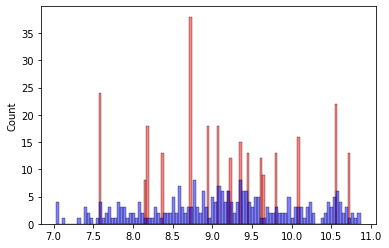

In [148]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=100)
sns.histplot(y_val, color='blue', alpha=0.5, bins=100)

In [147]:
y_val

array([ 9.12639757,  8.76254868,  8.6105491 , 10.46769662, 10.71463898,
        9.87901767,  9.05461093,  7.03649971,  8.54736035,  7.47326112,
        7.70641697,  9.1206291 ,  8.72006363,  9.98406628,  8.41807602,
        7.85819645,  9.83357042,  8.87668587,  9.60928538,  7.67571351,
       10.22321004,  9.95700718,  9.54697593,  9.21695972,  9.50534048,
        9.01435029,  7.14113348, 10.55278079,  8.71080523, 10.27337623,
        8.87826883, 10.12159383,  7.58779189,  9.53032732,  9.30259553,
        9.06007819,  9.30203767,  8.78709743,  8.79065625, 10.63770664,
        9.97457391,  9.10377455,  8.88221135,  7.8073075 ,  9.57864588,
        7.53845743,  8.63344065,  9.18250967,  9.70848845, 10.61991868,
        8.84533221,  9.84199215,  9.31237119,  7.99804167, 10.08115926,
        8.45972012,  9.98326546,  8.35252906,  9.76980221, 10.10211799,
        9.44093883,  8.7632097 ,  9.76208331,  7.91146884,  7.04786142,
        9.38816288,  7.39684651,  8.53328227,  9.23002262, 10.28

#### Random Forest Regressor

In [259]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [260]:
y_pred = rf.predict(X_val)
rmse(y_val, y_pred)

0.4364831937217117

In [261]:
scores = []

for n in range (10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)  
    scores.append((n, rmse(y_val, y_pred)))

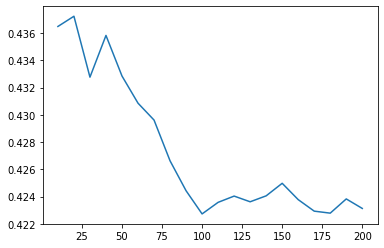

In [262]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [263]:
df_scores[df_scores.rmse == df_scores.rmse.min()]

,n_estimators,rmse
9,100,0.422722


In [264]:
values = [10, 15, 20, 25]
scores = []
for v in values:
    for n in range (10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1, max_depth = v)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)  
        scores.append((v, n, rmse(y_val, y_pred)))

In [265]:
df_scores

,n_estimators,rmse
0,10,0.436483
1,20,0.437233
2,30,0.432762
3,40,0.435825
4,50,0.432845
5,60,0.430852
6,70,0.429613
7,80,0.426620
8,90,0.424424
9,100,0.422722


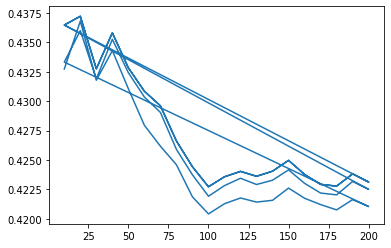

In [266]:
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [267]:
df_scores[df_scores.rmse == df_scores.rmse.min()]

,max_depth,n_estimators,rmse
9,10,100,0.420412


In [268]:
import xgboost as xgb
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

[0]	train-rmse:0.68793	val-rmse:0.71013
[1]	train-rmse:0.53701	val-rmse:0.57037
[2]	train-rmse:0.43764	val-rmse:0.49007
[3]	train-rmse:0.37631	val-rmse:0.44743
[4]	train-rmse:0.33660	val-rmse:0.42875
[5]	train-rmse:0.30794	val-rmse:0.42394
[6]	train-rmse:0.28705	val-rmse:0.42653
[7]	train-rmse:0.27421	val-rmse:0.42519
[8]	train-rmse:0.26188	val-rmse:0.42534
[9]	train-rmse:0.25294	val-rmse:0.42682
[10]	train-rmse:0.24636	val-rmse:0.42923
[11]	train-rmse:0.24212	val-rmse:0.43138
[12]	train-rmse:0.22849	val-rmse:0.43225
[13]	train-rmse:0.22547	val-rmse:0.43413
[14]	train-rmse:0.22001	val-rmse:0.43910
[15]	train-rmse:0.21502	val-rmse:0.43941
[16]	train-rmse:0.20673	val-rmse:0.44270
[17]	train-rmse:0.19865	val-rmse:0.44303
[18]	train-rmse:0.19474	val-rmse:0.44391
[19]	train-rmse:0.19201	val-rmse:0.44547
[20]	train-rmse:0.18989	val-rmse:0.44566
[21]	train-rmse:0.18485	val-rmse:0.44581
[22]	train-rmse:0.17878	val-rmse:0.44566
[23]	train-rmse:0.17684	val-rmse:0.44602
[24]	train-rmse:0.17080	va

[39]	train-rmse:0.12985	val-rmse:0.45014
[40]	train-rmse:0.12864	val-rmse:0.45160
[41]	train-rmse:0.12657	val-rmse:0.45111
[42]	train-rmse:0.12569	val-rmse:0.45111
[43]	train-rmse:0.12454	val-rmse:0.45189
[44]	train-rmse:0.12392	val-rmse:0.45187
[45]	train-rmse:0.12316	val-rmse:0.45237
[46]	train-rmse:0.12272	val-rmse:0.45229
[47]	train-rmse:0.12131	val-rmse:0.45260
[48]	train-rmse:0.11807	val-rmse:0.45321
[49]	train-rmse:0.11604	val-rmse:0.45329
[50]	train-rmse:0.11442	val-rmse:0.45301
[51]	train-rmse:0.11058	val-rmse:0.45348
[52]	train-rmse:0.10876	val-rmse:0.45363
[53]	train-rmse:0.10645	val-rmse:0.45336
[54]	train-rmse:0.10399	val-rmse:0.45334
[55]	train-rmse:0.10326	val-rmse:0.45384
[56]	train-rmse:0.10222	val-rmse:0.45345
[57]	train-rmse:0.10054	val-rmse:0.45386
[58]	train-rmse:0.10046	val-rmse:0.45389
[59]	train-rmse:0.09858	val-rmse:0.45412
[60]	train-rmse:0.09758	val-rmse:0.45452
[61]	train-rmse:0.09684	val-rmse:0.45465
[62]	train-rmse:0.09437	val-rmse:0.45550
[63]	train-rmse:

In [269]:
y_pred = model.predict(dval)
rmse(y_pred, y_val)

0.46465925448239626

### Train best model on full train data - Decision Tree Regressor

In [151]:
y_full_train = np.log1p(df_full_train.charges.values)
y_test = np.log1p(df_test.charges.values)
dv = DictVectorizer(sparse=False)
del df_full_train['charges']
del df_test['charges']
full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dicts)
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [153]:
dt = DecisionTreeRegressor(min_samples_leaf=35, random_state=1, max_depth = 6)
dt.fit(X_full_train, y_full_train)
y_pred = dt.predict(X_test)
rmse(y_pred, y_test)  

0.34602842130666156

In [ ]:
####### transform back to get real values 

df['logy'] = df['y'].apply(np.log)

In [154]:
import pickle

In [156]:
model = dt.fit(X_full_train, y_full_train)

with open("model.pkl", "wb") as f:
    pickle.dump((model), f)

with open("dv.bin", "wb") as f:
    pickle.dump((dv), f)   